# Are Baseball Lineups Optimal?
***Predicting outcomes of at-bats to optimize batting orders.***

## Business Understanding
**Sports Analytics**

In all sports, analytics are being used to leverage every possible advantage. In modern baseball particularly, there is a wealth of data: players prepare and improve their personal skills, managers position defenders in revolutionary ways, front offices use data to sign free agents and plan spending.

**Batting Orders**

Before a game is played, the manager (along with the coaching staff and front office) assigns a starting pitcher and a batting order. Starting pitchers are typically used  on a 5-day rotating schedule while batting orders are very often consistent for the season with an age-old "formula":
- *Your fastest player who's best at getting on base should bat first.*
- *Your best "contact"-hitter should bat second in order to advance the lead-off hitter.*
- *Your overall best hitter should bat third (hopefully with two players already on base).*
- *Your best power-hitter should hit fourth ("cleanup") to "clean up" the bases with a home-run ideally.*

... and so on down the batting order.

**Can we improve on tradition?**

There is some intuition to this - especially that your best hitters should be hitting near the top of the batting order so they have more of a chance to get more plate-appearances in a game (the batting order rotates 1-9 back to 1 again). However, this concept of placing the hitters in this order is a hundred years old and should be challenged.

### Objectives
1. Use ML / Neural Networks to model baseball "events" (plate appearances). The models will use player data (Pitchers and Hitters) as well as additional game-data (temperature, field condition, etc) to **predict the outcome of a plate appearance.** 
 - *The predictions will importantly be **probabilistic** - showing the probability of each possible outcome (e.g.: Single, Out, Sacrifice, Strikeout). Therefore, the model should acknowledge some randomness involved.*
    - *Ex: If a player were to come to the plate in an identical situation 100 times, the results would vary even though the circumstances do not.*
2. Once we are able to figure probabilities of each outcome in a given situation, we will be **finding the optimal batting order** (measured by *expected runs-scored*).
 - *We will be simulating innings and measuring runs-scored while iterating through lineups.*

**After the *optimization* is run, we will be able to say what batting order will produce the most runs on a given day against a given pitcher with given conditions.**

- **Name:** Claude Fried
- **Pace:** Part-time
- **Scheduled project review date/time:** Feb 11, 2021
- **Instructor name:** James Irving

### Imports

In [1]:
import os
import re
import pickle
import bz2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import (classification_report, 
                             balanced_accuracy_score, 
                             log_loss)
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import TruncatedSVD
from scipy import sparse

import tensorflow as tf

In [2]:
# Custom files.
import baseball_support as bsb
from league_player_classes import *

In [3]:
%matplotlib inline
plt.style.use(['ggplot', 'seaborn-talk'])
pd.set_option('display.max_columns', None)

# Set colors for plotting.
COLORS = {
    'blue': '#1f77b4',
    'green': '#2eb41f',
    'yellow': '#b4b21f',
    'red': '#b41f1f',
    'purple': '#b41f94',
    'grey': '#7d7d7d'
}

# Set random seed.
np.random.seed(2020)
tf.random.set_seed(2020)
tf.compat.v1.set_random_seed(2020)

# Check for device.
print(bsb.headerize(tf.test.gpu_device_name()))

# Make directory if it doesn't exist.
os.makedirs('./models', exist_ok=True)

********************************************************************************
*                                /device:GPU:0                                 *
********************************************************************************


# Obtain

## Data

The data is obtained and extracted from https://www.retrosheet.org/game.htm

Information on the event files can be found here: https://www.retrosheet.org/eventfile.htm

The players data can be found here: https://www.retrosheet.org/retroID.htm

> *The information used here was obtained free of charge from and is copyrighted by Retrosheet.*
> 
> *Interested parties may contact Retrosheet at 20 Sunset Rd., Newark, DE 19711.*

### Downloading & extracting data from files.

The script can be used from this directory in the terminal:
```bash
$ python scrape_data_to_csv.py -year 1950
```
...or in the cell below.

***

*It is not necessary to download any files manually.
If the directory `'./data'` does not exist, this file will download and unzip the necessary files and save them to the directory.*

***

The data used for training the model in this project will be starting from `1950`.

In [4]:
# Check for data.
# Scrape if './data' does not exist or if the files are missing.

##########################################
# `scrape_data_to_csv.py` takes ~3-5 min #
##########################################

if not bsb.check_for_data():
    %run scrape_data_to_csv.py -year 1950

********************************************************************************
*                             SUCCESS - Data Found                             *
********************************************************************************


### Files

**GAMES**

- `[game_id, visiting_team_id, home_team_id, site_id, date, dblhdr_number, day_night, temp, wind, field_cond, precip, time_of_game, attendance]`

**EVENTS**

- `[game_id, inning_num, inning_half, hitter_id, pitcher_id, outcome]`

**TEAMS**

- `[team_id, year, league, location, name]`

In [5]:
# Load in data.
games, events, teams = bsb.load_data()

games.shape, events.shape, teams.shape

((136888, 13), (10986116, 6), (1742, 5))

### Prepare `League`

*The league is a homemade object which is designed to house Players and their stats. The League can add and get Player objects, but most importantly can `populate_league_with(df)` which updates the `events` dataframe with up-to-date Player stats for each at-bat.*

In [6]:
MLB = League()
MLB


	**********LEAGUE**********
	Number of Hitters:  0
	Number of Pitchers: 0
	Total Players:      0

# Scrub

***Garbage in, garbage out.***

Since we scraped through a series of files that are formated pretty similarly, we can expect consistency with our data. We can also acknowledge that since we acquired the data ourselves and formatted it how we like, many of the issues with "*dirty data*" don't exist.

There are some things that we need to work on however with the data we have.

**The first thing to do is make sure the dtypes are correct and that missing values are addressed.**

## Games

Our `games` data can give us descriptive points on the games themselves - date, weather, day/night, sometimes field condition.

In [7]:
games.head()

,game_id,visiting_team_id,home_team_id,site_id,date,dblhdr_number,day_night,temp,wind,field_cond,precip,time_of_game,attendance
0,NYA195006100,SLA,NYA,NYC16,1950/06/10,0,day,0,-1,unknown,unknown,154,13765
1,SLA195006170,NYA,SLA,STL07,1950/06/17,0,day,0,-1,unknown,unknown,121,2824
2,SLA195006181,NYA,SLA,STL07,1950/06/18,1,day,0,-1,unknown,unknown,193,0
3,SLA195006182,NYA,SLA,STL07,1950/06/18,2,day,0,-1,unknown,unknown,133,14190
4,CHA195006200,BOS,CHA,CHI10,1950/06/20,0,night,0,-1,unknown,unknown,137,35578


In [8]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136888 entries, 0 to 136887
Data columns (total 13 columns):
game_id             136888 non-null object
visiting_team_id    136888 non-null object
home_team_id        136888 non-null object
site_id             136888 non-null object
date                136888 non-null object
dblhdr_number       136888 non-null int64
day_night           136888 non-null object
temp                136887 non-null object
wind                136887 non-null object
field_cond          136887 non-null object
precip              136887 non-null object
time_of_game        136888 non-null int64
attendance          136888 non-null int64
dtypes: int64(3), object(10)
memory usage: 14.6+ MB


In [9]:
# Fix dtypes.
games['date'] = pd.to_datetime(games['date'])

for c in ('temp', 'wind'):
    games[c] = pd.to_numeric(games[c], errors='coerce')
    if c == 'temp':
        # Correct "missing."
        games[c] = games[c].map(lambda x: -1 if x == 0 else x)
    games[c] = games[c].astype(float)

In [10]:
# Fill in missing values.
games.loc[games['site_id'].isna(), 
          'site_id'] = games[games['site_id'].isna()]['home_team_id']

games['temp'] = games['temp'].fillna(-1.0)
games['wind'] = games['wind'].fillna(-1.0)
games['field_cond'] = games['field_cond'].fillna('unknown')

# Time of game will be dropped.
games['time_of_game'] = games['time_of_game'].fillna(0.0)
games['time_of_game'] = games['time_of_game'].astype(int)

games['precip'] = games['precip'].fillna('unknown')

games.loc[((games['attendance'].isna()) | 
           (games['attendance'] == 0.0)),
          'attendance'] = -1

games['attendance'] = games['attendance'].astype(int)

In [11]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136888 entries, 0 to 136887
Data columns (total 13 columns):
game_id             136888 non-null object
visiting_team_id    136888 non-null object
home_team_id        136888 non-null object
site_id             136888 non-null object
date                136888 non-null datetime64[ns]
dblhdr_number       136888 non-null int64
day_night           136888 non-null object
temp                136888 non-null float64
wind                136888 non-null float64
field_cond          136888 non-null object
precip              136888 non-null object
time_of_game        136888 non-null int32
attendance          136888 non-null int32
dtypes: datetime64[ns](1), float64(2), int32(2), int64(1), object(7)
memory usage: 13.6+ MB


## Events

This is our main data. Each row represents an at-bat with the `hitter_id` and `pitcher_id` to decipher *who the outcome "belongs" to.*

In [12]:
events.head()

,game_id,inning_num,inning_half,hitter_id,pitcher_id,outcome
0,NYA195006100,1,0,lenhd101,reyna102,6/P
1,NYA195006100,1,0,kokod101,reyna102,K
2,NYA195006100,1,0,lolls101,reyna102,4/L
3,NYA195006100,1,1,rizzp101,stard102,13/BG
4,NYA195006100,1,1,mapec101,stard102,HP


In [13]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10986116 entries, 0 to 10986115
Data columns (total 6 columns):
game_id        object
inning_num     int64
inning_half    int64
hitter_id      object
pitcher_id     object
outcome        object
dtypes: int64(2), object(4)
memory usage: 586.7+ MB


In [14]:
events.isna().sum()

game_id        0
inning_num     0
inning_half    0
hitter_id      0
pitcher_id     0
outcome        0
dtype: int64

## Teams

This simple table shows us the teams that were competing in the league each year. Teams change locations, change names, change leagues, etc. This keeps track of that information.

In [15]:
teams.head()

,team_id,year,league,location,name
0,BOS,1950,A,Boston,Red Sox
1,CHA,1950,A,Chicago,White Sox
2,CLE,1950,A,Cleveland,Indians
3,DET,1950,A,Detroit,Tigers
4,NYA,1950,A,New York,Yankees


In [16]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1742 entries, 0 to 1741
Data columns (total 5 columns):
team_id     1742 non-null object
year        1742 non-null int64
league      1742 non-null object
location    1742 non-null object
name        1742 non-null object
dtypes: int64(1), object(4)
memory usage: 81.7+ KB


## Players

We have created a `PlayerFinder` class which will make the player table useful.

Our players table gives us player names and debut dates. We may use the debut column to see if we have complete records of a certain player who played at the start of our data.

The `PlayerFinder` can search for `player_ids` from names, as well as returning full names from `player_ids`.

In [17]:
playerfinder = bsb.PlayerFinder()
playerfinder


	**********PLAYER FINDER**********
	Number of player records loaded: 21284

In [18]:
# Example usage:
playerfinder.show_player('Griffey')
print('\n####################\n')
print(playerfinder.get_player_name('grifk001'))

             last first play_debut mgr_debut coach_debut ump_debut
id                                                                
grifk001  Griffey   Ken 1973-08-25       NaN  04/06/1993       NaN
grifk002  Griffey   Ken 1989-04-03       NaN         NaN       NaN

####################

Ken Griffey


## Engineer 

### `outcome`

Our main feature of the entire dataset is the `outcome` column from the events table. Each "event" is summarized with an outcome.

There are many types of outcomes - commonly hits & outs, but also *caught stealing* and *catcher's interference* are possible results of plays.

We must summarize the `outcome` column in order to have usable data to work with. The first part to this is to decipher the event "language" into the most meaningful parts.

In [19]:
# Example.
events['outcome'][:10]

0             6/P
1               K
2             4/L
3           13/BG
4              HP
5    K+CS2(26)/DP
6              13
7               K
8           D7/7L
9              31
Name: outcome, dtype: object

In [20]:
##########################################################
# This processing (`engineer_outcome()`) takes ~1-2 min. #
##########################################################

# Load in pre-engineered events if exists.
if 'events_processed_outcome.pkl' in os.listdir('./data'):
    events = pd.read_pickle('./data/events_processed_outcome.pkl')

# Run `engineer_outcome()` to gather appropriate features from this column.
else:
    events = pd.concat(
        [events.drop('outcome', axis=1), 
         bsb.engineer_outcome(events['outcome'])], 
        axis=1
        )
    
    # Save results.
    events.to_pickle('./data/events_processed_outcome.pkl')

In [21]:
# Drop events which don't involve an outcome for the batter.
print('Number of No-Outcome Plays:', 
      f"{events['outcome'].isna().sum()}/{events.shape[0]}",
      '\nPercent Total:             ',
      f"{round(events['outcome'].isna().sum()/events.shape[0], 3)}%")
events.dropna(inplace=True)

events.head()

Number of No-Outcome Plays: 0/10779597 
Percent Total:              0.0%


,game_id,inning_num,inning_half,hitter_id,pitcher_id,outcome,total_bases,date,prior_outcome_lag1,prior_outcome_lag2,prior_outcome_lag3,prior_outcome_lag4,prior_outcome_lag5,h_ab_coming_in,h_k%_coming_in,h_ops_coming_in,p_ip_coming_in,p_whip_coming_in,p_k_bb_coming_in
10409,BOS195004180,1,0,rizzp101,parnm101,K,0.0,1950-04-18,NONE,NONE,NONE,NONE,NONE,0,-1.0,-1.0,0.000000,-1.0,-1.0
10410,BOS195004180,1,0,henrt101,parnm101,O,0.0,1950-04-18,K,NONE,NONE,NONE,NONE,0,-1.0,-1.0,0.333333,0.0,-1.0
10411,BOS195004180,1,0,baueh101,parnm101,O,0.0,1950-04-18,O,K,NONE,NONE,NONE,0,-1.0,-1.0,0.666667,0.0,-1.0
10412,BOS195004180,1,1,dimad101,reyna102,S,1.0,1950-04-18,NONE,NONE,NONE,NONE,NONE,0,-1.0,-1.0,0.000000,-1.0,-1.0
10413,BOS195004180,1,1,peskj101,reyna102,S,1.0,1950-04-18,S,NONE,NONE,NONE,NONE,0,-1.0,-1.0,0.000000,-1.0,-1.0


In [22]:
events.shape

(10779597, 19)

## Add `date` and `prior_outcome` to `events`

In [23]:
if 'date' not in events.columns: # If not already saved and loaded.
    events = pd.merge(events, games[['game_id', 'date']], on='game_id')
    
events.sort_values(['date', 'game_id', 'inning_num', 'inning_half'], 
                   inplace=True)
events.head()

,game_id,inning_num,inning_half,hitter_id,pitcher_id,outcome,total_bases,date,prior_outcome_lag1,prior_outcome_lag2,prior_outcome_lag3,prior_outcome_lag4,prior_outcome_lag5,h_ab_coming_in,h_k%_coming_in,h_ops_coming_in,p_ip_coming_in,p_whip_coming_in,p_k_bb_coming_in
10409,BOS195004180,1,0,rizzp101,parnm101,K,0.0,1950-04-18,NONE,NONE,NONE,NONE,NONE,0,-1.0,-1.0,0.000000,-1.0,-1.0
10410,BOS195004180,1,0,henrt101,parnm101,O,0.0,1950-04-18,K,NONE,NONE,NONE,NONE,0,-1.0,-1.0,0.333333,0.0,-1.0
10411,BOS195004180,1,0,baueh101,parnm101,O,0.0,1950-04-18,O,K,NONE,NONE,NONE,0,-1.0,-1.0,0.666667,0.0,-1.0
10412,BOS195004180,1,1,dimad101,reyna102,S,1.0,1950-04-18,NONE,NONE,NONE,NONE,NONE,0,-1.0,-1.0,0.000000,-1.0,-1.0
10413,BOS195004180,1,1,peskj101,reyna102,S,1.0,1950-04-18,S,NONE,NONE,NONE,NONE,0,-1.0,-1.0,0.000000,-1.0,-1.0


In [24]:
##################################
# This processing takes ~20 min. #
##################################

# Engineer `prior_outcome` columns with lag-1 through lag-5.
# `lag` columns show the previous outcomes of the current inning.
if 'prior_outcome_lag5' not in events.columns:
    lag1 = []
    lag2 = []
    lag3 = []
    lag4 = []
    lag5 = []

    lag5_outcome = None
    lag4_outcome = None
    lag3_outcome = None
    lag2_outcome = None
    last_outcome = None
    curr_inning_half = None

    for idx, row in events.iterrows():
        if row['inning_half'] != curr_inning_half: # row where the inning flips
            curr_inning_half = row['inning_half'] # set new inning half
            lag1.append('NONE') # no prior for first ab in inning
            lag2.append('NONE')
            lag3.append('NONE')
            lag4.append('NONE')
            lag5.append('NONE')
        else:
            # Judging based on the last values in each lag-list.
            if lag1[-1] == 'NONE':
                lag2.append('NONE')
                lag3.append('NONE')
                lag4.append('NONE')
                lag5.append('NONE')
            elif lag2[-1] == 'NONE':
                lag2.append(lag2_outcome)
                lag3.append('NONE')
                lag4.append('NONE')
                lag5.append('NONE')
            elif lag3[-1] == 'NONE':
                lag2.append(lag2_outcome)
                lag3.append(lag3_outcome)
                lag4.append('NONE')
                lag5.append('NONE')
            elif lag4[-1] == 'NONE':
                lag2.append(lag2_outcome)
                lag3.append(lag3_outcome)
                lag4.append(lag4_outcome)
                lag5.append('NONE')
            else:
                lag2.append(lag2_outcome)
                lag3.append(lag3_outcome)
                lag4.append(lag4_outcome)
                lag5.append(lag5_outcome)
            lag1.append(last_outcome)
            
        # Set lag- values
        lag5_outcome = lag4_outcome
        lag4_outcome = lag3_outcome
        lag3_outcome = lag2_outcome
        lag2_outcome = last_outcome
        last_outcome = row['outcome']

    events['prior_outcome_lag1'] = lag1
    events['prior_outcome_lag2'] = lag2
    events['prior_outcome_lag3'] = lag3
    events['prior_outcome_lag4'] = lag4
    events['prior_outcome_lag5'] = lag5
    
    # Save
    events.to_pickle('./data/events_processed_outcome.pkl')

events[
    ['inning_half', 
     'outcome', 
     'prior_outcome_lag1', 
     'prior_outcome_lag2',
     'prior_outcome_lag3',
     'prior_outcome_lag4',
     'prior_outcome_lag5']
].head(20)

,inning_half,outcome,prior_outcome_lag1,prior_outcome_lag2,prior_outcome_lag3,prior_outcome_lag4,prior_outcome_lag5
10409,0,K,NONE,NONE,NONE,NONE,NONE
10410,0,O,K,NONE,NONE,NONE,NONE
10411,0,O,O,K,NONE,NONE,NONE
10412,1,S,NONE,NONE,NONE,NONE,NONE
10413,1,S,S,NONE,NONE,NONE,NONE
10414,1,D,S,S,NONE,NONE,NONE
10415,1,S,D,S,S,NONE,NONE
10416,1,K,S,D,S,S,NONE
10417,1,S,K,S,D,S,S
10418,1,O,S,K,S,D,S


### Player statistics

There are certain "live" stats for the players that can be used for modeling. 
- `{'stat'}_coming_in`, or "entering the at-bat" based on past performance.

They can also be used to hone in on the pinnacle of the player's career - the player's "prime" (which I'm not sure yet if I will use).

For the purposes of this model, I'll be satisfied to have everyone's stats begin at the earliest records we have available.

#### Stats

##### Offense (Hitters)
- **AB**: At-Bats
  - Simply the number of times the player records a statistical "at-bat". (Also referred to as *Plate Appearances*)
- **K%**: *Strikeout Rate*
  - Strikeouts per plate appearance.
- **OPS**: *On-Base Plus Slugging*
  - This stat combines two of the most valuable offensive stats we have in the game - on base percentage (how often a player reaches base) and slugging percentage (how many bases a player gets per hit).

> $\small OBP = \frac{H+BB+HBP}{AB+BB+SF+HBP}$
> 
> $\small SLG = \frac{TB}{AB}$
> 
> $\large OPS = OBP + SLG$

##### Defense (Pitchers)
- **IP**: Innings Pitched
  - Simply the number of innings pitched. Conventionally this is shown as `{innings}.{thirds_of_an_inning}` (e.g. $6.2 = 6 \frac{2}{3} innings$). We will be calculating and showing this as proper floats (e.g. $6.67 = 6 \frac{2}{3} innings$) so the calculations associated are correct.
- **WHIP**: *Walks plus Hits per Inning Pitched*
  - This stat tells simply how many base-runners a pitcher allows per inning pitched.
- **K/BB**: Strikeout to Walk Ratio
  - Exactly as it sounds - this stat shows how many strikeouts a pitcher achieves compared to how many walks they allow.

# Populating the League

At this point we can run `League.populate_league_with(data)` which does two things:
1. Create Players and career stats for every `player_id` in the dataset.
2. Update the data to include `{stat}_coming_in` for hitters and pitchers.

At the end of this process, our League will have all players and their rolling stats (one entry per "event").

Our data will also include `{stat}_coming_in`.

In [25]:
#############################################
# - Loading the file takes ~ 45-60 sec.     #
# - Populating the league takes ~ 30-35 min.#
#############################################
f_name = './data/populated_league.pkl'

# Load in "pre-trained" League & updated `events`.
if 'populated_league.pkl' in os.listdir('./data'):
    print('Loading...')
    with bz2.open(f_name, 'rb') as infile:
        MLB = pickle.load(infile)
    events = pd.read_pickle('./data/events_processed_outcome.pkl')
    print('Complete.')
    
# Populate League and save `events`.
else:
    print('Processing...')
    MLB.populate_league_with(events)
    sfile = bz2.BZ2File(f_name, 'w')
    pickle.dump(MLB, sfile)
    events.to_pickle('./data/events_processed_outcome.pkl')
    print('Complete.')

Loading...
Complete.


In [26]:
MLB


	**********LEAGUE**********
	Number of Hitters:  10104
	Number of Pitchers: 6416
	Total Players:      16520

In [27]:
events.head()

,game_id,inning_num,inning_half,hitter_id,pitcher_id,outcome,total_bases,date,prior_outcome_lag1,prior_outcome_lag2,prior_outcome_lag3,prior_outcome_lag4,prior_outcome_lag5,h_ab_coming_in,h_k%_coming_in,h_ops_coming_in,p_ip_coming_in,p_whip_coming_in,p_k_bb_coming_in
10409,BOS195004180,1,0,rizzp101,parnm101,K,0.0,1950-04-18,NONE,NONE,NONE,NONE,NONE,0,-1.0,-1.0,0.000000,-1.0,-1.0
10410,BOS195004180,1,0,henrt101,parnm101,O,0.0,1950-04-18,K,NONE,NONE,NONE,NONE,0,-1.0,-1.0,0.333333,0.0,-1.0
10411,BOS195004180,1,0,baueh101,parnm101,O,0.0,1950-04-18,O,K,NONE,NONE,NONE,0,-1.0,-1.0,0.666667,0.0,-1.0
10412,BOS195004180,1,1,dimad101,reyna102,S,1.0,1950-04-18,NONE,NONE,NONE,NONE,NONE,0,-1.0,-1.0,0.000000,-1.0,-1.0
10413,BOS195004180,1,1,peskj101,reyna102,S,1.0,1950-04-18,S,NONE,NONE,NONE,NONE,0,-1.0,-1.0,0.000000,-1.0,-1.0


# Explore

Here we can explore and visualize the data. 

We can observe the outcomes themselves *(the `event` level)*, as well as how the Players and Player-stats impact the outcome *(the `player` level)*.

In [28]:
# Include data on games (eg: weather, time, attendance, etc)
data = pd.merge(events.drop('date', axis=1), games, on='game_id')
data.to_pickle('./data/data.pkl')
data.columns

Index(['game_id', 'inning_num', 'inning_half', 'hitter_id', 'pitcher_id',
       'outcome', 'total_bases', 'prior_outcome_lag1', 'prior_outcome_lag2',
       'prior_outcome_lag3', 'prior_outcome_lag4', 'prior_outcome_lag5',
       'h_ab_coming_in', 'h_k%_coming_in', 'h_ops_coming_in', 'p_ip_coming_in',
       'p_whip_coming_in', 'p_k_bb_coming_in', 'visiting_team_id',
       'home_team_id', 'site_id', 'date', 'dblhdr_number', 'day_night', 'temp',
       'wind', 'field_cond', 'precip', 'time_of_game', 'attendance'],
      dtype='object')

## Events

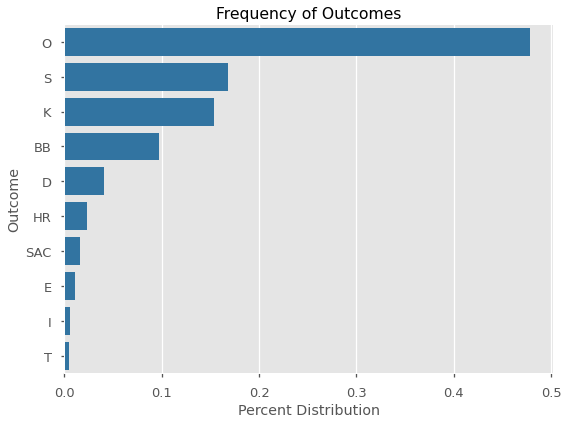

In [29]:
# Outcome frequency
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='outcome', y='index', orient='h', 
            data=data['outcome'].value_counts(normalize=True).reset_index(),
            color=COLORS['blue'], ax=ax)
ax.set(title='Frequency of Outcomes',
       ylabel='Outcome',
       xlabel='Percent Distribution')
fig.tight_layout()
fig.savefig('./images/frequency_of_outcomes.png', transparent=True)

*Almost half of all outcomes are Outs (and far more than half if Strikeouts are included) - which makes sense considering every game has 54 outs, and far fewer hits.*

*It's very interesting that Triples are just about as rare as Defensive Interference.*

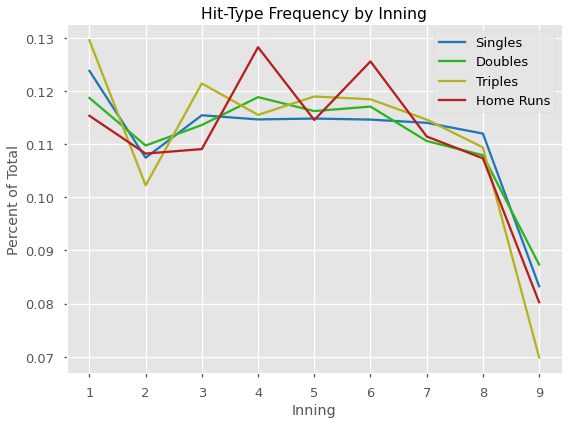

In [30]:
def get_outcome_type(events_df, outcome):
    """Queries events df for outcome-type frequency within first 9 innings."""
    
    return events_df[
        (events_df['outcome'] == outcome) & (events_df['inning_num'] <= 9)
    ]['inning_num'].value_counts(normalize=True).reset_index()


# Hit outcomes by inning.
fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(x='index', y='inning_num',
             data=get_outcome_type(data, 'S'), 
             label='Singles', color=COLORS['blue'], ax=ax)
sns.lineplot(x='index', y='inning_num',
             data=get_outcome_type(data, 'D'), 
             label='Doubles', color=COLORS['green'], ax=ax)
sns.lineplot(x='index', y='inning_num',
             data=get_outcome_type(data, 'T'), 
             label='Triples', color=COLORS['yellow'], ax=ax)
sns.lineplot(x='index', y='inning_num',
             data=get_outcome_type(data, 'HR'), 
             label='Home Runs', color=COLORS['red'], ax=ax)

ax.set(title='Hit-Type Frequency by Inning',
       ylabel='Percent of Total',
       xlabel='Inning')
fig.tight_layout()
fig.savefig('./images/hit_type_by_inning.png', transparent=True)

*I find this plot very exciting. It seems there is a spike of HomeRuns in the 4th inning - typically when the top of the order comes to the plate for the second time.*

*Conventional wisdom suggests that the second time a lineup faces a pitcher in a game, the more likely they are to do well. This suggests some truth in that.*

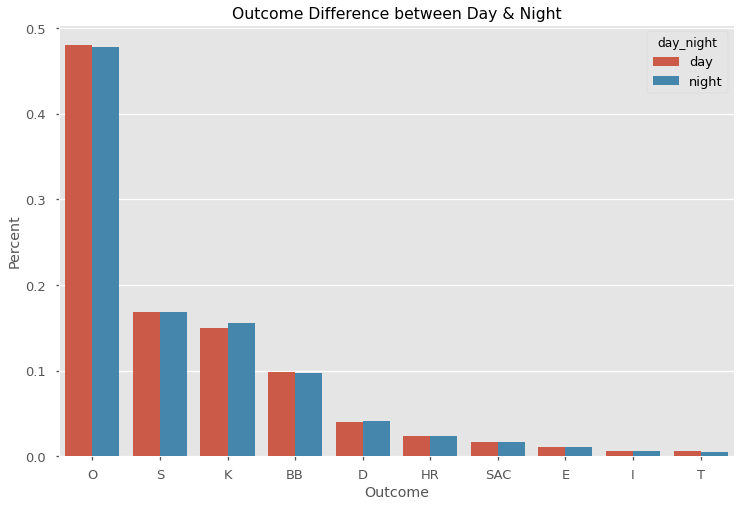

In [31]:
# Difference between day and night games.
fig, ax = plt.subplots()
sns.barplot(x='outcome', 
            y='percent',
            hue='day_night', 
            data=(data.groupby('day_night')['outcome']
                  .value_counts(normalize=True)
                  .rename('percent')
                  .reset_index()),
            ax=ax)
ax.set(title='Outcome Difference between Day & Night',
       xlabel='Outcome',
       ylabel='Percent')
fig.tight_layout()
fig.savefig('./images/day_night.png', transparent=True)

*There does not seem to be a significant difference between day games and night games.*

## Hitters

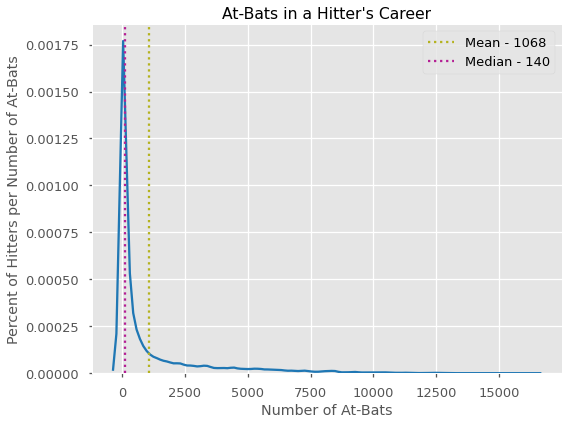

In [32]:
# Number of at-bats in a player's career.
total_ab = np.array([len(hitter.rolling_stats) 
                     for hitter in MLB.hitters.values()])
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(total_ab, hist=False, color=COLORS['blue'])
ax.axvline(total_ab.mean(), 
           label=f'Mean - {round(total_ab.mean())}', 
           ls=':', 
           color=COLORS['yellow'])
ax.axvline(np.median(total_ab), 
           label=f'Median - {round(np.median(total_ab))}', 
           ls=':', 
           color=COLORS['purple'])
ax.set(title="At-Bats in a Hitter's Career",
       xlabel='Number of At-Bats',
       ylabel='Percent of Hitters per Number of At-Bats')
ax.legend()
fig.tight_layout()
fig.savefig('./images/at_bats_hitter.png', transparent=True)

*Most players have very short careers - but some have very long careers!*

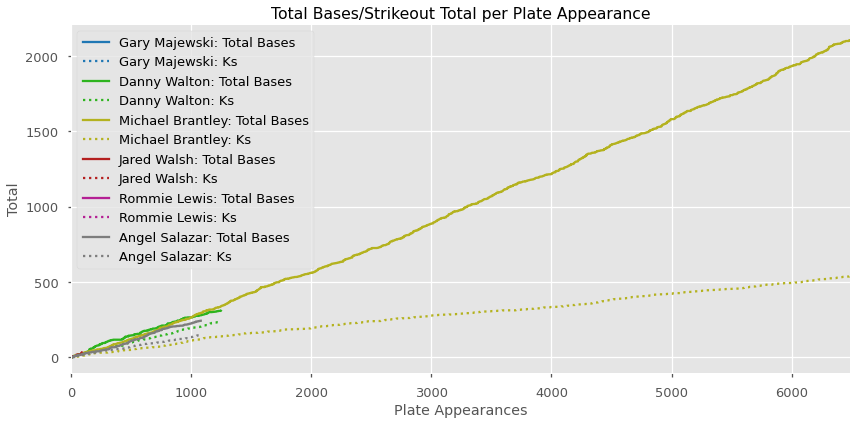

In [33]:
# Plotting random sample of Total Bases & Strikeouts.
random_hitter_sample = np.random.choice(
    [hitter for hitter in MLB.hitters.values()], 
    6, 
    replace=False
    )

fig, ax = plt.subplots(figsize=(12,6))
for hitter, color in zip(random_hitter_sample, COLORS.values()):
    hitter.get_rolling_stats_df()['tb'].plot(
        color=color, 
        label=playerfinder.get_player_name(hitter.player_id) + ': Total Bases',
        ax=ax
        )
    hitter.get_rolling_stats_df()['k'].plot(
        color=color,
        ls=':',
        label=playerfinder.get_player_name(hitter.player_id) + ': Ks',
        ax=ax
        )
ax.set(title='Total Bases/Strikeout Total per Plate Appearance',
       xlabel='Plate Appearances',
       ylabel='Total')
ax.legend()
fig.tight_layout()
fig.savefig('./images/total_bases_k_total.png', transparent=True)

*This plot, along with the following, suggest that there is a correlation between difference between Total Bases and Strikeouts and the number of plate appearances the player has in their career.*

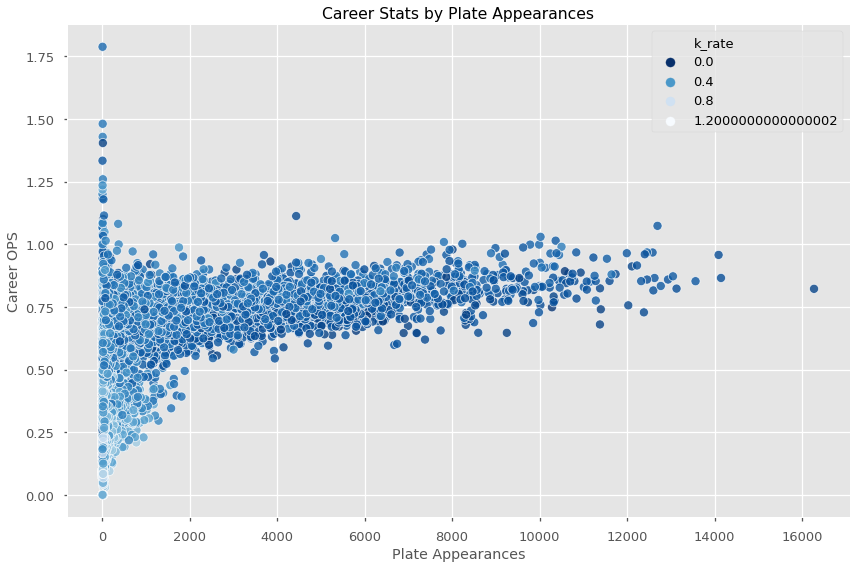

In [34]:
fig, ax = plt.subplots(figsize=(12,8))

# y=Career SLG
# x=Career Plate Appearances
ops_pa = pd.DataFrame([
    {'ops': hitter._Hitter__get_ops(),
     'k_rate': hitter._Hitter__get_strikeout_rate(),
     'pa': len(hitter.rolling_stats)}
    for hitter in MLB.hitters.values()
])

sns.scatterplot(x='pa', y='ops', hue='k_rate', 
                data=ops_pa[ops_pa['pa'] > 10], 
                palette='Blues_r',
                alpha=0.8,
                ax=ax)
ax.set(title='Career Stats by Plate Appearances',
       xlabel='Plate Appearances',
       ylabel='Career OPS')
fig.tight_layout()
fig.savefig('./images/ops_k_rate_plate_appearances.png', transparent=True)

*This shows that there's a "professional range" of OPS. There are no players who have lower than 0.500 OPS with more than 2000 at-bats in their career.*

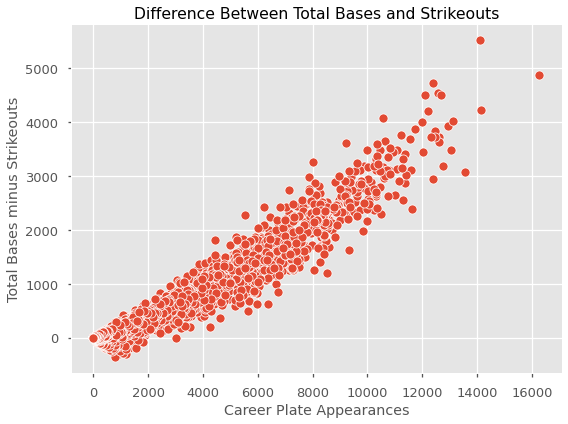

In [35]:
# Total bases minus strikeouts.
hits_rate_df = pd.DataFrame([
    {'bases_minus_k': hitter.career_stats['tb'] - hitter.career_stats['k'],
     'pa': len(hitter.rolling_stats)}
    for hitter in MLB.hitters.values()
])

fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='pa', y='bases_minus_k', data=hits_rate_df, ax=ax)
ax.set(title='Difference Between Total Bases and Strikeouts',
       xlabel='Career Plate Appearances',
       ylabel='Total Bases minus Strikeouts')
fig.tight_layout()
fig.savefig('./images/total_bases_k_total_difference.png', transparent=True)

*As suggested before, there is a strong correlation between TotalBases - Strikeouts and CareerAtBats.*

## Pitchers

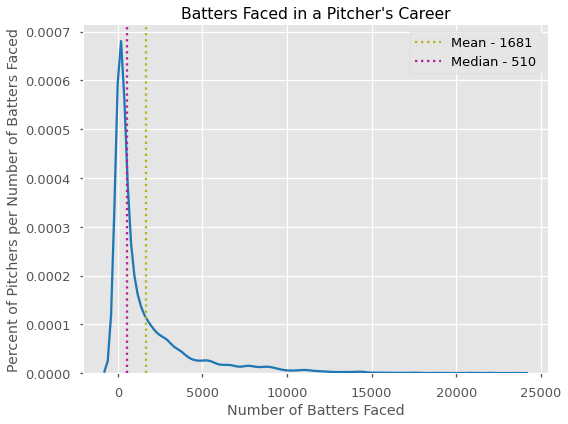

In [36]:
# Career batters faced.
total_batters_faced = np.array([len(pitcher.rolling_stats) 
                                for pitcher in MLB.pitchers.values()])
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(total_batters_faced, hist=False, color=COLORS['blue'])
ax.axvline(total_batters_faced.mean(), 
           label=f'Mean - {round(total_batters_faced.mean())}', 
           ls=':', 
           color=COLORS['yellow'])
ax.axvline(np.median(total_batters_faced), 
           label=f'Median - {round(np.median(total_batters_faced))}', 
           ls=':', 
           color=COLORS['purple'])
ax.set(title="Batters Faced in a Pitcher's Career",
       xlabel='Number of Batters Faced',
       ylabel='Percent of Pitchers per Number of Batters Faced')
ax.legend()
fig.tight_layout()
fig.savefig('./images/at_bats_pitcher.png', transparent=True)

*Similar to hitters, most pitchers don't last long in the league while some have very long careers.*

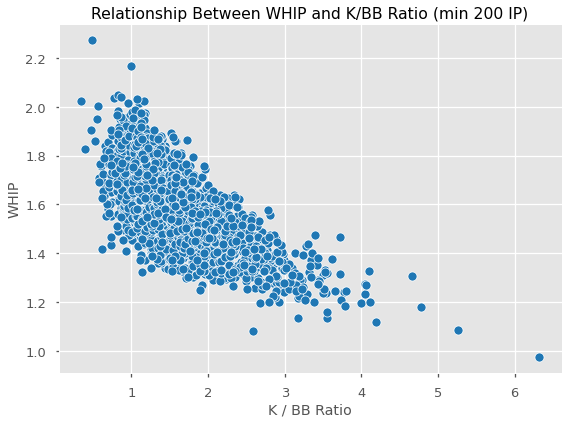

In [37]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(
    x='k_bb', 
    y='whip', 
    color=COLORS['blue'],
    ax=ax,
    data=pd.DataFrame([(pitcher._Pitcher__get_whip(), 
                        pitcher._Pitcher__get_k_bb_ratio())
                       for pitcher in MLB.pitchers.values()
                       if pitcher._Pitcher__get_ip() > 200], 
                      columns=['whip', 'k_bb'])
    )
ax.set(title='Relationship Between WHIP and K/BB Ratio (min 200 IP)',
       xlabel='K / BB Ratio',
       ylabel='WHIP')
fig.tight_layout()
fig.savefig('./images/whip_k_bb_ratio.png', transparent=True)

*There seems to be a gentle exponential decay when comparing a pitcher's WHIP to strikeout-to-walk ratio.*

*Pitchers with a low strikeout-to-walk ratio have a higher WHIP, which makes sense since they are inverse metrics of skill (pitchers want a high K/BB Ratio and a low WHIP).*

## Player Impact on Outcome

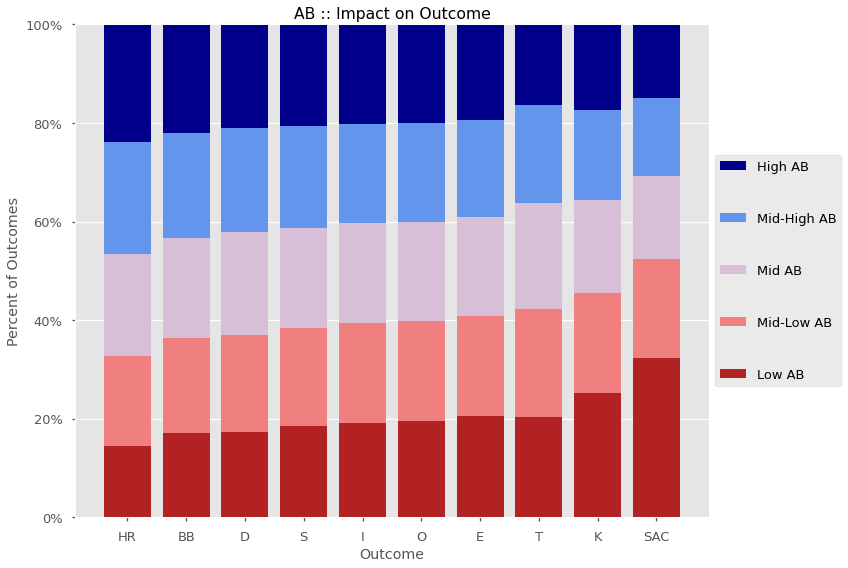

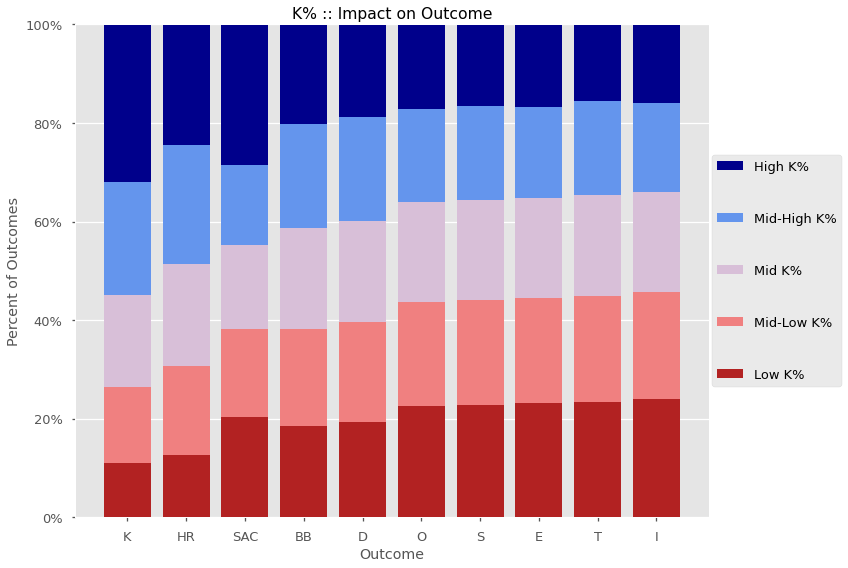

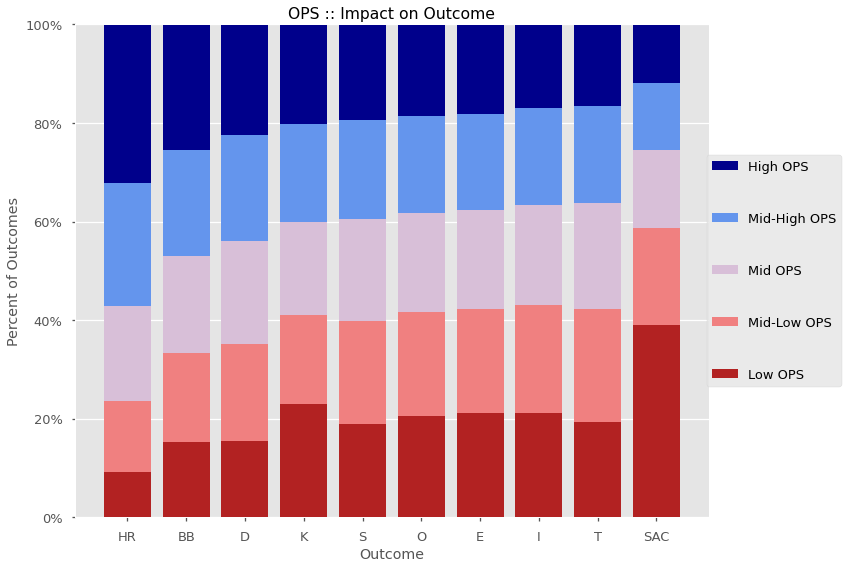

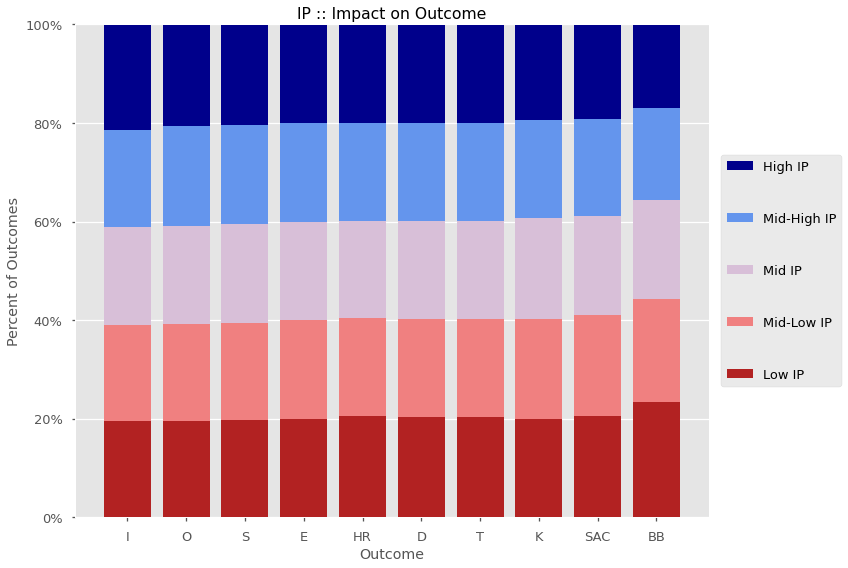

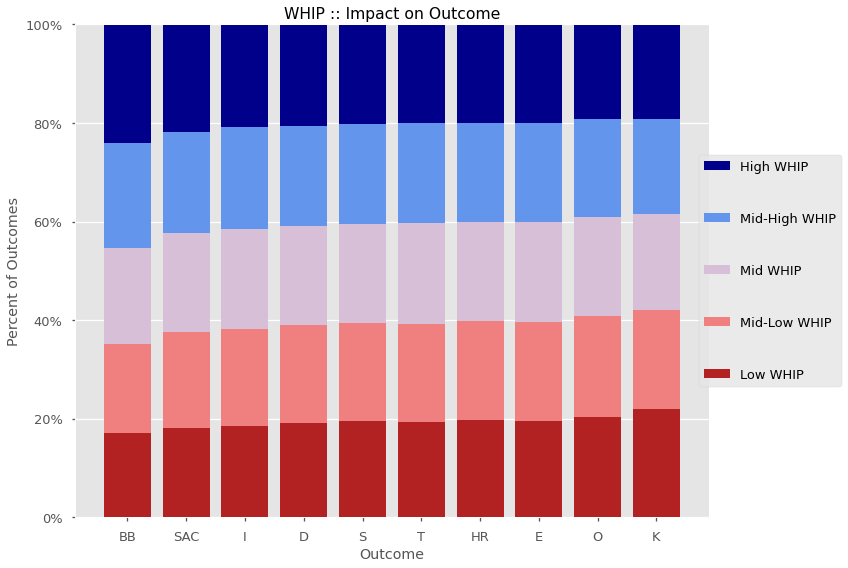

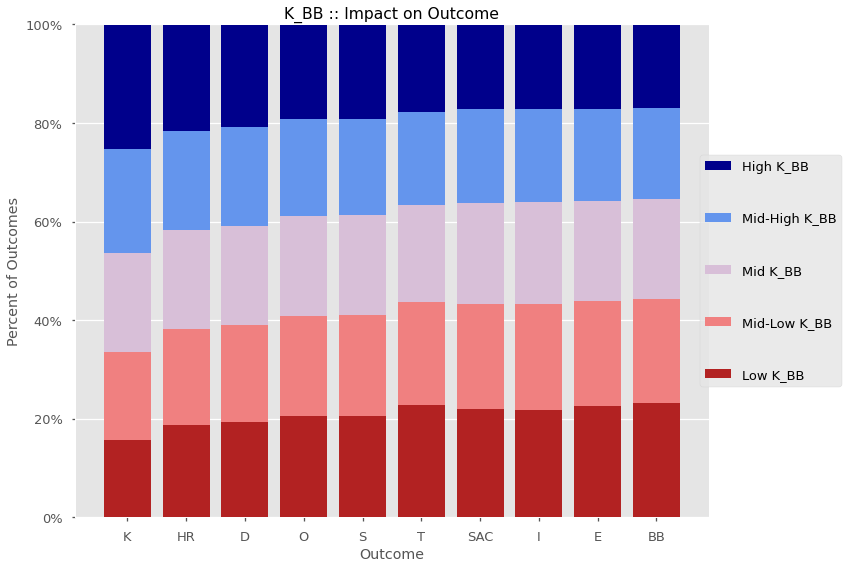

In [38]:
# Get (stat, abbreviation) from `{stat}_coming_in` columns.
coming_in_stats = [(col, col.split('_coming_in')[0][2:]) 
                   for col in events.columns if col.endswith('coming_in')]

for col, abbr in coming_in_stats:
    fig = bsb.plot_stat_impact_on_outcome(
        df=events, 
        stat_column=col, 
        legend_label=abbr.upper())
    fig.savefig(f'./images/impact_on_outcome_{abbr}.png', transparent=True)

*Each of these is interesting for its own reason. From a broad sense however, it's interesting how impactful the Hitter stats are compared to the Pitcher stats.*

# Prepare Data for Modeling

In [39]:
# Drop unneeded columns.
to_drop = [
    'game_id', 'total_bases', 'date', 
    'visiting_team_id', 'home_team_id', 
    'site_id', 'time_of_game'
]
data.drop(columns=to_drop, inplace=True)

# Create test data.
TEST_SIZE = int(data.drop('outcome', axis=1).shape[0] * 0.15)

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('outcome', axis=1), 
    data['outcome'],
    test_size=TEST_SIZE,
    random_state=2020,
    stratify=data['outcome']
)

# Create validation data.
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=TEST_SIZE,
    random_state=2020,
    stratify=y_train
)

print('Train:', X_train.shape, y_train.shape)
print('Val:  ', X_val.shape, y_val.shape) 
print('Test: ', X_test.shape, y_test.shape)

Train: (7545719, 22) (7545719,)
Val:   (1616939, 22) (1616939,)
Test:  (1616939, 22) (1616939,)


In [40]:
# Set up ColumnTransformer to process data.
def make_column_transformer():
    """Returns a fresh ColumnTransformer for use with this data."""
    
    cat_feats = ['hitter_id', 
                 'pitcher_id', 
                 'prior_outcome_lag1', 
                 'prior_outcome_lag2', 
                 'prior_outcome_lag3', 
                 'prior_outcome_lag4', 
                 'prior_outcome_lag5', 
                 'day_night', 
                 'field_cond', 
                 'precip']
    cat_trans = OneHotEncoder(handle_unknown='ignore')

    num_feats = [
        'inning_num',
        'inning_half',
        'h_ab_coming_in',
        'h_k%_coming_in',
        'h_ops_coming_in',
        'p_ip_coming_in',
        'p_whip_coming_in',
        'p_k_bb_coming_in',
        'dblhdr_number',
        'temp',
        'wind',
        'attendance'
    ]
    num_trans = StandardScaler()

    X_preprocessor = ColumnTransformer([
        ('cat', cat_trans, cat_feats),
        ('num', num_trans, num_feats)
    ])
    return X_preprocessor


X_preprocessor = make_column_transformer()
X_preprocessor

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('cat',
                                 OneHotEncoder(categorical_features=None,
                                               categories=None, drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='ignore',
                                               n_values=None, sparse=True),
                                 ['hitter_id', 'pitcher_id',
                                  'prior_outcome_lag1', 'prior_outcome_lag2',
                                  'prior_outcome_lag3', 'prior_outcome_lag4',
                                  'prior_outcome_lag5', 'day_night',
                                  'field_cond', 'precip']),
                                ('num',
                                 StandardScaler(copy=True, with_mean=True,
         

In [41]:
X_train_processed = X_preprocessor.fit_transform(X_train)
X_test_processed = X_preprocessor.transform(X_test)
X_val_processed = X_preprocessor.transform(X_val)

X_train_processed.shape, X_test_processed.shape, X_val_processed.shape

((7545719, 16415), (1616939, 16415), (1616939, 16415))

In [42]:
y_preprocessor = LabelEncoder()
y_preprocessor

LabelEncoder()

In [43]:
y_train_processed = y_preprocessor.fit_transform(y_train)
y_test_processed = y_preprocessor.transform(y_test)
y_val_processed = y_preprocessor.transform(y_val)

y_train_processed.shape, y_test_processed.shape, y_val_processed.shape

((7545719,), (1616939,), (1616939,))

In [44]:
WEIGHTS_DCT = dict(
    zip(np.unique(y_train_processed), 
        compute_class_weight('balanced', 
                              np.unique(y_train_processed), 
                              y_train_processed)
       )
)
WEIGHTS_DCT

{0: 1.0265795506336433,
 1: 2.4547385440184257,
 2: 9.322262579840135,
 3: 4.277909494976982,
 4: 17.693849364535946,
 5: 0.651461223404439,
 6: 0.20910320040126254,
 7: 0.5931884555850702,
 8: 6.1270098656164995,
 9: 18.309963359297274}

## Save

In [45]:
# Save preprocessors and weights.
modeling_preprocessors = [
    ('X_preprocessor', X_preprocessor),
    ('y_preprocessor', y_preprocessor),
    ('WEIGHTS_DCT', WEIGHTS_DCT)
]
for name, tool in modeling_preprocessors:
    print(f'Saving:\t{name}...')
    with open(f'./modeling/preprocessor/{name}.pkl', 'wb') as sfile:
        pickle.dump(tool, sfile)

# Save sparse matrices.
modeling_data = [
    ('X_train_processed', X_train_processed),
    ('X_test_processed', X_test_processed),
    ('y_train_processed', y_train_processed),
    ('y_test_processed', y_test_processed),
    ('X_val_processed', X_val_processed),
    ('y_val_processed', y_val_processed)
]
for name, tool in modeling_data:
    print(f'Saving:\t{name}...')
    if type(tool) == sparse.csr.csr_matrix:
        sparse.save_npz(f'./modeling/data/{name}.npz', tool)
    else:
        sparse.save_npz(f'./modeling/data/{name}.npz', sparse.csr_matrix(tool))
        
print('Complete!')

Saving:	X_preprocessor...
Saving:	y_preprocessor...
Saving:	WEIGHTS_DCT...
Saving:	X_train_processed...
Saving:	X_test_processed...
Saving:	y_train_processed...
Saving:	y_test_processed...
Saving:	X_val_processed...
Saving:	y_val_processed...
Complete!


In [46]:
# Save a special `modeling_league` which has only career stats for each player.
for hitter in MLB.hitters:
    MLB.hitters[hitter]._Player__delete_rolling_stats()
for pitcher in MLB.pitchers:
    MLB.pitchers[pitcher]._Player__delete_rolling_stats()

In [47]:
MLB.get_player('rizzp101').rolling_stats

[]

In [48]:
MLB.get_player('rizzp101').career_stats

{'bb': 394, 'k': 193, 'h': 738, 'sac': 122, 'tb': 954.0, 'ab': 2629}

In [49]:
pickle.dump(MLB, open('./data/populated_league_sm.pkl', 'wb'))

# *Modeling in notebook: `capstone_modeling_outcomes_colab.ipynb`*

The modeling for this project was done on Google Colab and can be found in the sister notebook in this repo: `capstone_modeling_outcomes_colab.ipynb`

There, we model:
- Sklearn
  - SGD LogReg
  - Decision Tree
- Tensorflow
  - FFNN
    - With and Without Class_Weights
  
Finally, we run Validation for the models against real-season data and compare the difference between lineup-shuffles.

# Conclusions

The Simulations showed conclusively that changing a batting order will change the expected results. There was a huge shift in performance between 100 randomly-shuffled lineups. Over the course of 162 games (one regular-season), the disadvantage of using sub-optimal lineups would add up to be a severe detriment.

***

The models showed that scoring well for accuracy is not possible, since in sports there is a definite aspect of randomness (i.e.: on a given day, any player can get the better of any other player). However, in basing our judgments on cross-entropy loss, we find the model which was able to return the most accurate prediction-probabilities was a Neural Network without class weights.

However, since deployment on *heroku* was a factor, the size and speed of the model influenced the decision. While the Neural Net was the most accurate (by a slim margin), the SGD Logistic Regression Classifier was much more light-weight and scored nearly the same cross-entropy loss on the test set. Therefore, this is the best model for this particular situation. 

Class weights, for this specific problem, were more of a detriment than an asset for the model - since the model was much more prone to overfitting on the less-frequent classes. This doesn't make sense, as there isn't any reasonable way to be able to predict if there will be a catcher's interference on the next play, or that the next play will most likely be a triple. 

However, those outcomes are *possible* and incorporated into the Simulator app.

***

## Recommendations:

***1. Batting order matters!***
- There is a huge difference in performance from one lineup-configuration to another.
- When setting your lineup, remember that there are more factors than just *who do I feel should hit where?* Opposing pitchers' tendencies, game conditions, and lineup interactions should be at the forefront of your decision-making process.
- **Lineups should change regularly** to leverage different advantages against different pitchers.
  - The web app can be used to optimize your lineup of players to return the order with the highest 'expected runs scored'.

***2. Find players with a large difference between 'total bases' and strikeouts.***
- When evaluating talent, there is a direct correlation between *number of career at bats* and *difference between total-bases and strikeouts*. Hitters who balance the number of bases they get from hits and number of times they strike out (essentially a wasted at-bat in most cases) have longer careers than those who either strike out too much *or* don't hit for enough bases.

### Modeling Recommendations
1. The more detail in the data, the better the predictions will be. Incorporating the players live statistics, as well as the dynamic features of *'What just happened this inning?'* are very important to add dimensions.
2. A neural network is very prone to overfitting, so the number of training epochs should be small. It does no good for the network to just "memorize" the training data.
3. Additionally, adding in class weights hurts performance. It is a similar case of overfitting. 
  - For example, if the model is rewarded too strongly for predicting a catcher's interference, it will behave very poorly - i.e.: predict that there's an 80% chance that in the upcoming play, the catcher will interfere with the batter. It is clear that this is not ideal behavior of the model.